In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr
import utils_plots as ut

In [8]:
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')

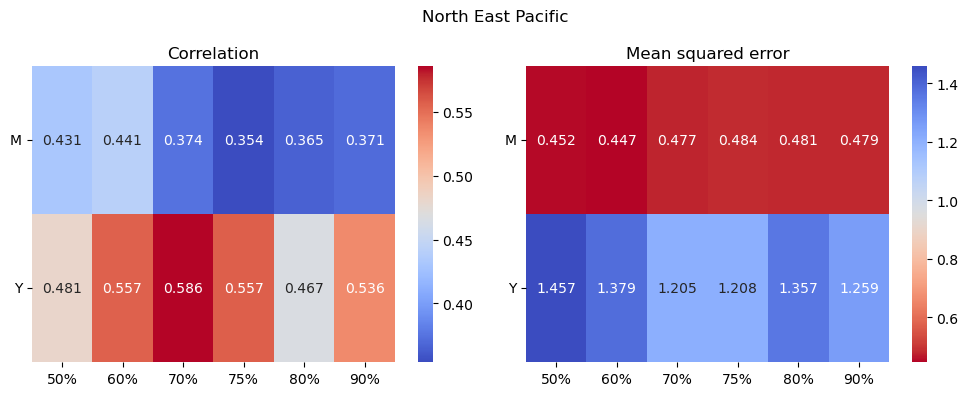

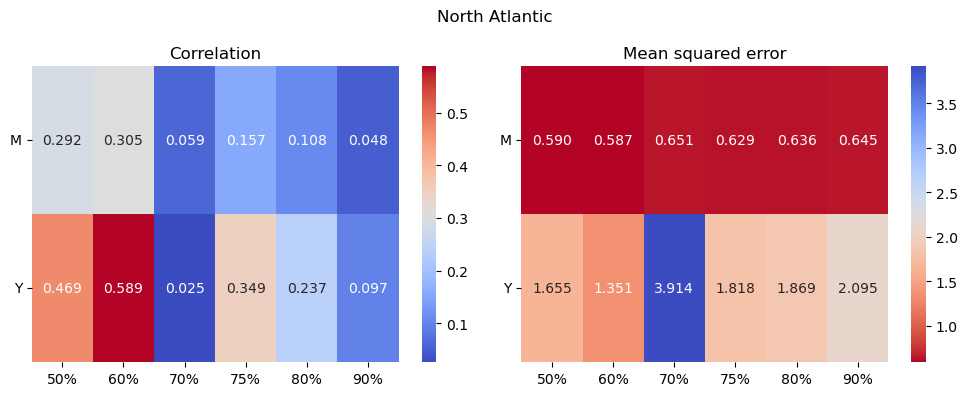

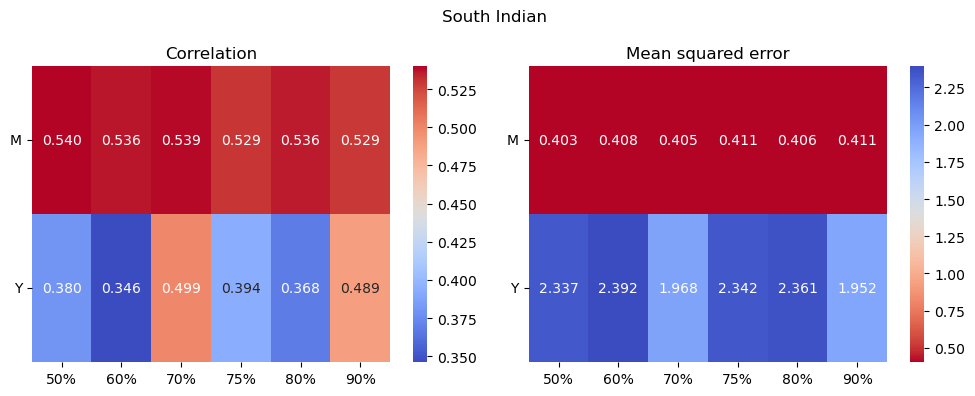

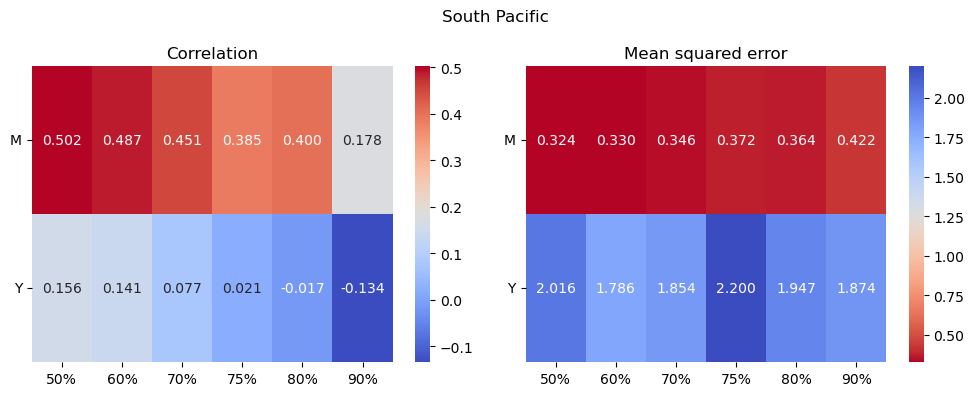

In [ ]:
basin_dict = {'NEP': ('North East Pacific', 9), 
              'NWP': ('North West Pacific', 8), 
              'NA': ('North Atlantic', 12),
              'NI': ('North Indian', 9), 
              'SI': ('South Indian', 10), 
              'SP': ('South Pacific', 11)}
for basin, (basin_name, n_clusters) in basin_dict.items():
    run_names = [f'selfeat50_top20_nc{n_clusters}_nv8_nd9_noTS', f'selfeat60_top20_nc{n_clusters}_nv8_nd9_noTS', f'selfeat70_top20_nc{n_clusters}_nv8_nd9_noTS', 
                 f'selfeat75_top20_nc{n_clusters}_nv8_nd9_noTS', f'selfeat80_top20_nc{n_clusters}_nv8_nd9_noTS', f'selfeat90_top20_nc{n_clusters}_nv8_nd9_noTS']
    col_perc = [run.split('_')[0].split('feat')[1] for run in run_names]
    df_corr = pd.DataFrame(0.0, index=['rM', 'rY'], columns=col_perc)
    df_mse = pd.DataFrame(0.0, index=['mseM', 'mseY'], columns=col_perc)
    for run_name in run_names:
        # Get the folder containing the cluster data
        cluster_data = f'{basin}_{n_clusters}clusters_noTS'
        cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
        # target
        target_file = 'target_residual_1980-2022_2.5x2.5.csv'
        target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
        target_df.index = pd.to_datetime(target_df.index)
        target_df = target_df.loc[target_df.index.year.isin(years)]
        # Get the run info and data
        Y_pred, Y_pred_noFS, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, perm_importance_mlp, perm_importance_mlp_noFS, shap_values_mlp, shap_values_mlp_noFS = ut.runs_info(basin, run_name)
        # Convert list of dataframes to a single dataframe
        X_test = pd.concat(X_test_eval)
        X_test_noFS = pd.concat(X_test_eval_noFS)
        Y_pred_df = pd.concat(Y_pred)
        Y_pred_noFS_df = pd.concat(Y_pred_noFS)
        # Annual data without trend and seasonality
        target_df_annual = target_df.groupby(target_df.index.year).sum()
        Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
        Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
        # Compute the correlation coefficient and the MSE between the predictions and the test values
        # Monthly without trend and seasonality
        r, _ = pearsonr(target_df['resid'], Y_pred_df['resid'])
        mse = mean_squared_error(target_df['resid'], Y_pred_df['resid'])
        # Annual without trend and seasonality
        rY, _ = pearsonr(target_df_annual['resid'], Y_pred_df_annual['resid'])
        mseY = mean_squared_error(target_df_annual['resid'], Y_pred_df_annual['resid'])
        # Store the results
        perc = run_name.split('_')[0].split('feat')[1]
        df_corr.loc['rM', perc] = r
        df_corr.loc['rY', perc] = rY
        df_mse.loc['mseM', perc] = mse
        df_mse.loc['mseY', perc] = mseY
    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(df_corr, annot=True, fmt=".3f", cmap='coolwarm', ax=ax[0])
    ax[0].set_title('Correlation')
    sns.heatmap(df_mse, annot=True, fmt=".3f", cmap='coolwarm_r', ax=ax[1])
    ax[1].set_title('Mean squared error')
    xtick_labels = ['50%', '60%', '70%', '75%', '80%', '90%']
    for a in ax:
        a.set_xticks(np.arange(len(xtick_labels), dtype=float)+0.5)
        a.set_xticklabels(xtick_labels)
        a.set_yticks(np.arange(2, dtype=float)+0.5)
        a.set_yticklabels(['M', 'Y'], rotation=0)
    fig.suptitle(f'{basin_name}')
    plt.tight_layout()
plt.show()